# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [203]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [204]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Потому что predict_proba возвращает вероятности принадлежности к классу. Мы используем Uniform, поэтому вероятности принадлежности к каждому классу одинаковые. Ну а класса всего два, поэтому получаем 0.5 (функция по дефолту генерирует n_classes=2, т.е. бинарную классификацию)

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [205]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


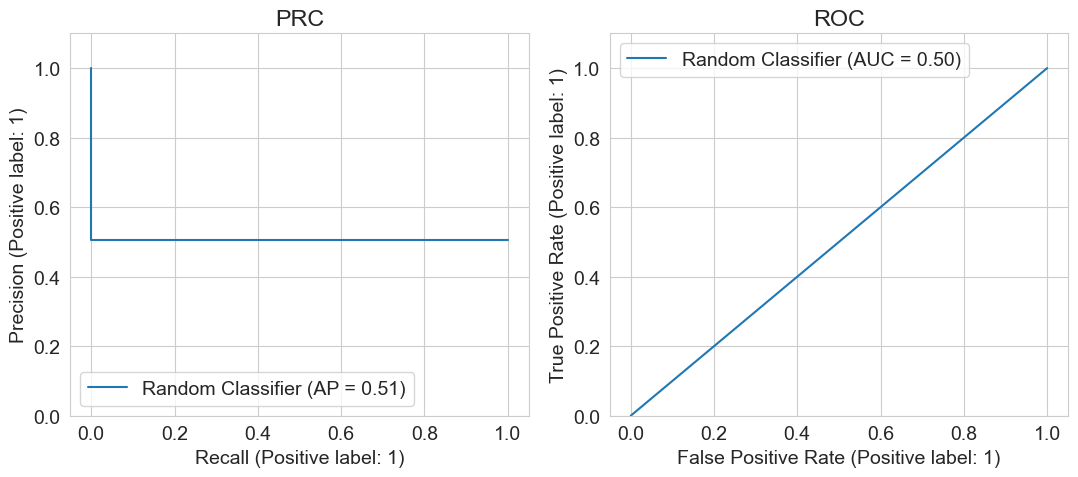

In [206]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [207]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [208]:
import warnings

warnings.filterwarnings('ignore')

In [209]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score

svc = LinearSVC(max_iter=100000)

pr_auc_scorer = make_scorer(average_precision_score, grater_is_better=True)

param_grid = {'C': np.logspace(-5, 5, 10)}
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring=pr_auc_scorer)
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']
best_score = grid_search.best_score_

print('best C:', best_C)

best C: 1e-05


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

LinearSVC classifier metrics
AUC-PR: 0.82961
AUC-ROC: 0.83485


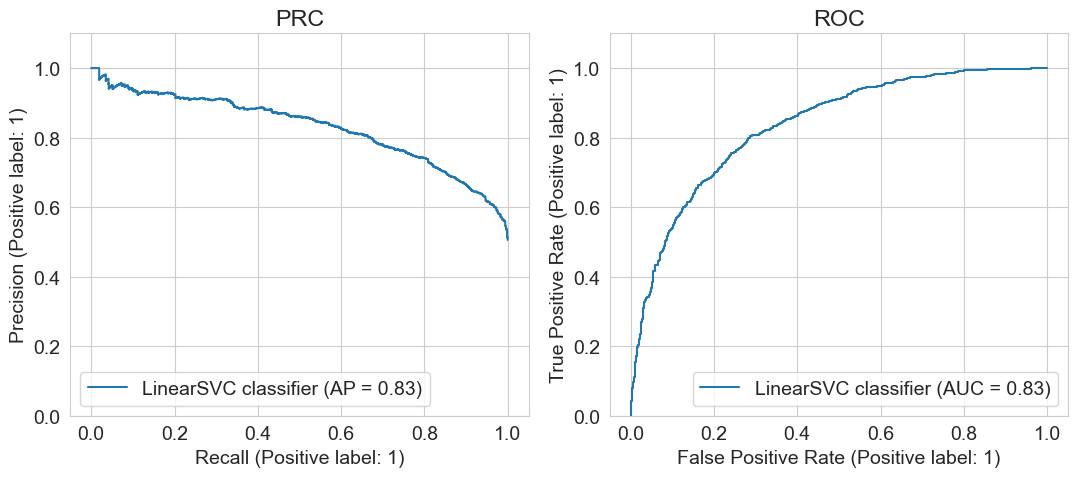

In [210]:
svc_pred = grid_search.decision_function(X_test)

depict_pr_roc(y_test, svc_pred, 'LinearSVC classifier')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [211]:
precision, recall, _ = precision_recall_curve(y_test, svc_pred)
df_metrics.loc['LinearSVC Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, svc_pred),
      best_C
      
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.00000
LinearSVC Classifier,0.829610,0.834846,0.00001


Видим, что модель, обученная с помощью SVC дала метрики намного лучше. Мы знаем, что чем ближе метрики к 1, тем лучше качество модели. Однако преимущество AUC_PR кривой в том, что она не чувствительна к несбалансированным классам.

Ну, а у нас и auc_roc и auc_pr дали результаты лучше, чем рандомный классификатор. 

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [212]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=100000)

pr_auc_scorer = make_scorer(average_precision_score, grater_is_better=True)

param_grid = {'C': np.logspace(-5, 5, 10)}
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring=pr_auc_scorer)
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']

print('best C:', best_C)

best C: 1e-05


Log Regression classifier metrics
AUC-PR: 0.81639
AUC-ROC: 0.82067


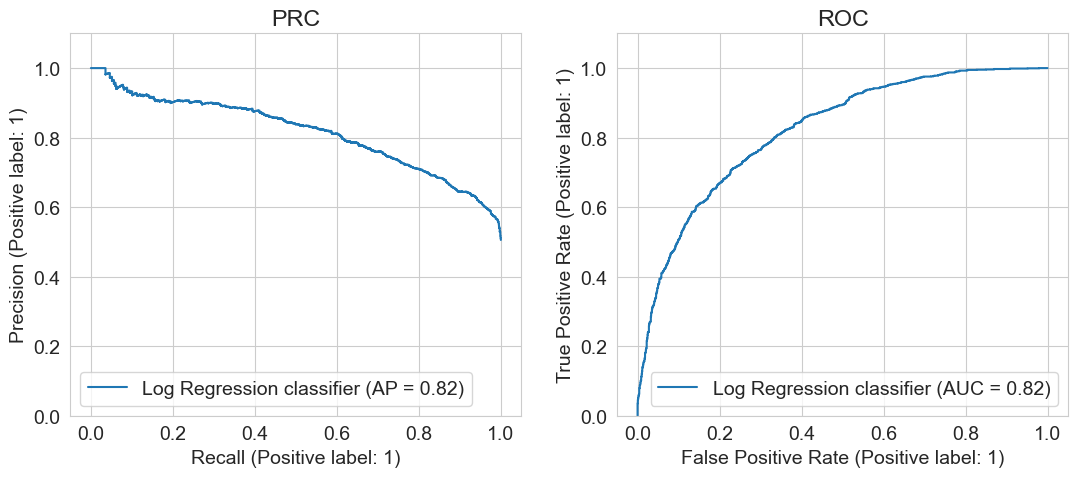

In [213]:
log_reg_pred = grid_search.predict_proba(X_test)
depict_pr_roc(y_test, log_reg_pred[:, 1], 'Log Regression classifier')

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

In [214]:
precision, recall, _ = precision_recall_curve(y_test, log_reg_pred[:, 1])
df_metrics.loc['Log Regression Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, log_reg_pred[:, 1]),
      best_C
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.00000
LinearSVC Classifier,0.829610,0.834846,0.00001
Log Regression Classifier,0.816388,0.820673,0.00001


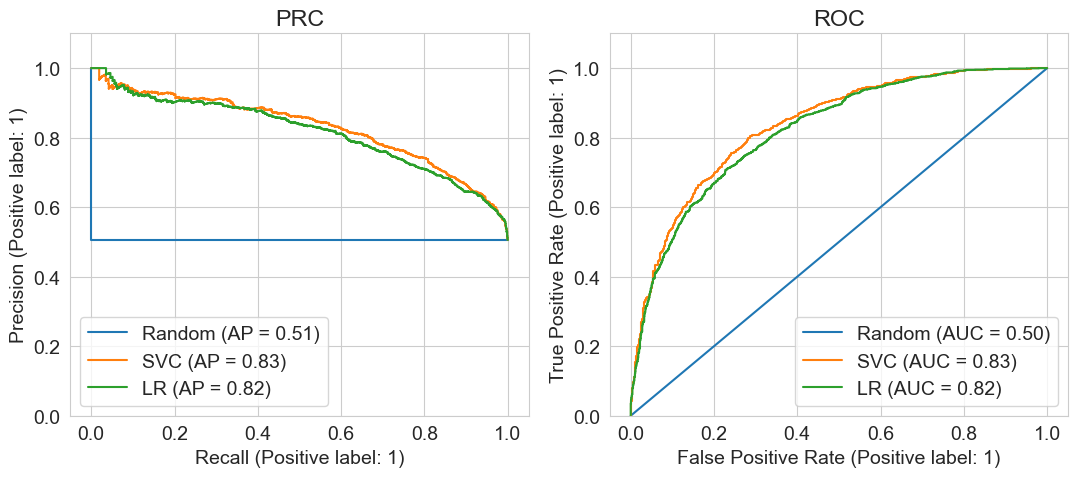

In [215]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0], name='Random')
PrecisionRecallDisplay.from_predictions(y_test, svc_pred, ax=ax[0], name='SVC')
PrecisionRecallDisplay.from_predictions(y_test, log_reg_pred[:, 1], ax=ax[0], name='LR')

ax[0].set_title("PRC")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1], name='Random')
RocCurveDisplay.from_predictions(y_test, svc_pred, ax=ax[1], name='SVC')
RocCurveDisplay.from_predictions(y_test, log_reg_pred[:, 1], ax=ax[1], name='LR')

ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.legend()
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** 

Получили вполне ожидаемый результат. В связи со спецификой функции потерь этих двух методов с лекций мы знаем, что SVC приводит к лучшему значению метрик качества, в то время как LR стремится более корректно оценить вероятности для классов. Таким образом, получили, что оба классификатора значительно лучше рандомного, однако метрики качество SVC обгоняют LR

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [216]:
#your code here
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [217]:
from sklearn.svm import SVC

In [218]:
svc = SVC(kernel='linear', max_iter=100000)

svc.fit(X_train, y_train)


SVC(kernel='linear', max_iter=100000)

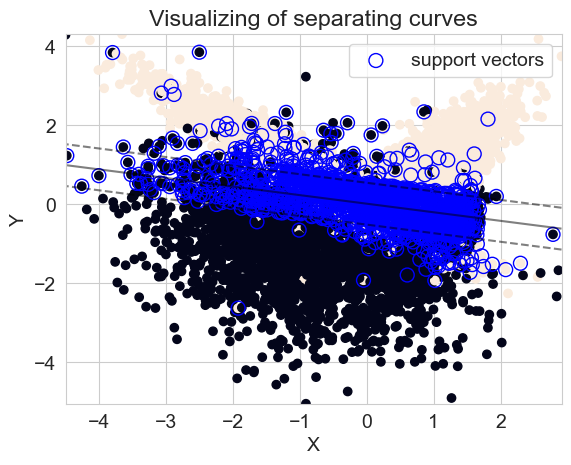

In [219]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')
    plt.title('Visualizing of separating curves')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()

plot_svm_2D(X, y, svc)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Видим, что в качестве опорных объектов выделяются в первую очередь объекты, которые нахоядтся между отступами.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [220]:
logreg_model = LogisticRegression(max_iter=100000)
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=100000)

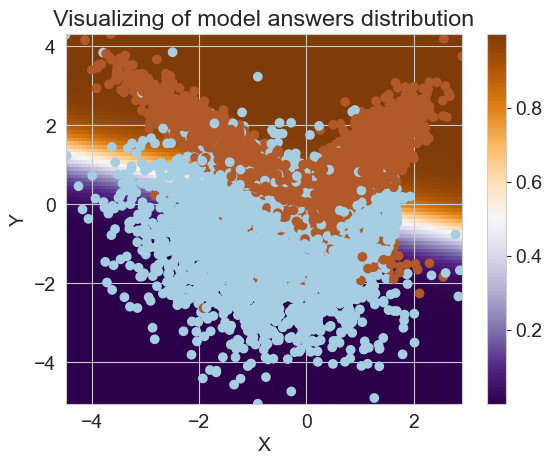

In [221]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1],
                cmap=plt.cm.Paired, c=y)
    plt.title('Visualizing of model answers distribution')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(image)


plot_logreg_2D(X, y, logreg_model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Такая область показывается светлым цветом (белым). Это как раз линия разделения классов, где данные смешиваются и модель сомневается, к какому классу отнести объект

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [222]:
def plot_calibration_curve(y_test, preds, model_name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label=f'{model_name} Сurve')
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.plot([0, 1], [0, 1], linestyle='--', label='Ideal Curve')
    plt.ylabel('Positive Ratio')
    plt.xlabel('Probabilities')
    plt.title(f'Calibration curve of {model_name}')
    plt.grid()
    plt.legend()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

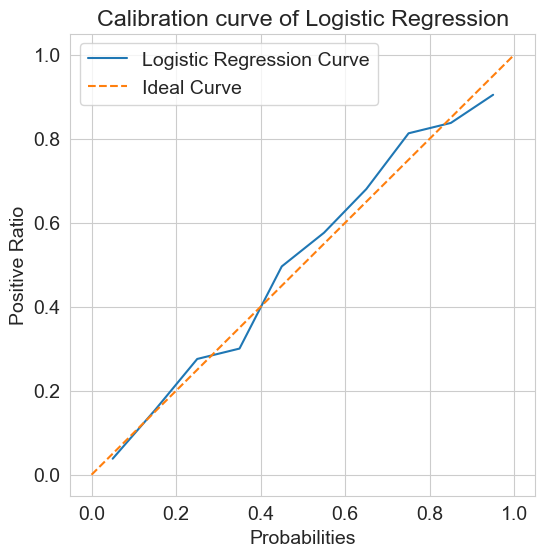

In [223]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression(max_iter=100000)
logreg.fit(X_train, y_train)

logreg_pred = logreg.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, logreg_pred, 'Logistic Regression')

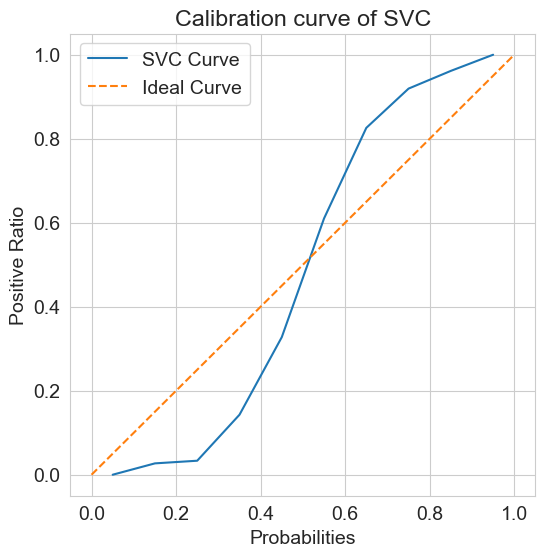

In [224]:
svc = LinearSVC(max_iter=100000, C=1e-5)

svc.fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
plot_calibration_curve(y_test, svc_pred, 'SVC')

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** Видим, что кривая для LR откалибрована очень хорошо, что в принципе ожидаемо, ведь этот метод по построению пытается максимально правильно предсказывать вероятности. Для SVC же кривая откалибрована плохо, что тоже ожидаемо. SVC выдает лучшее качество разделения на классы, но предсказывает вероятности не очень хорошо.

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

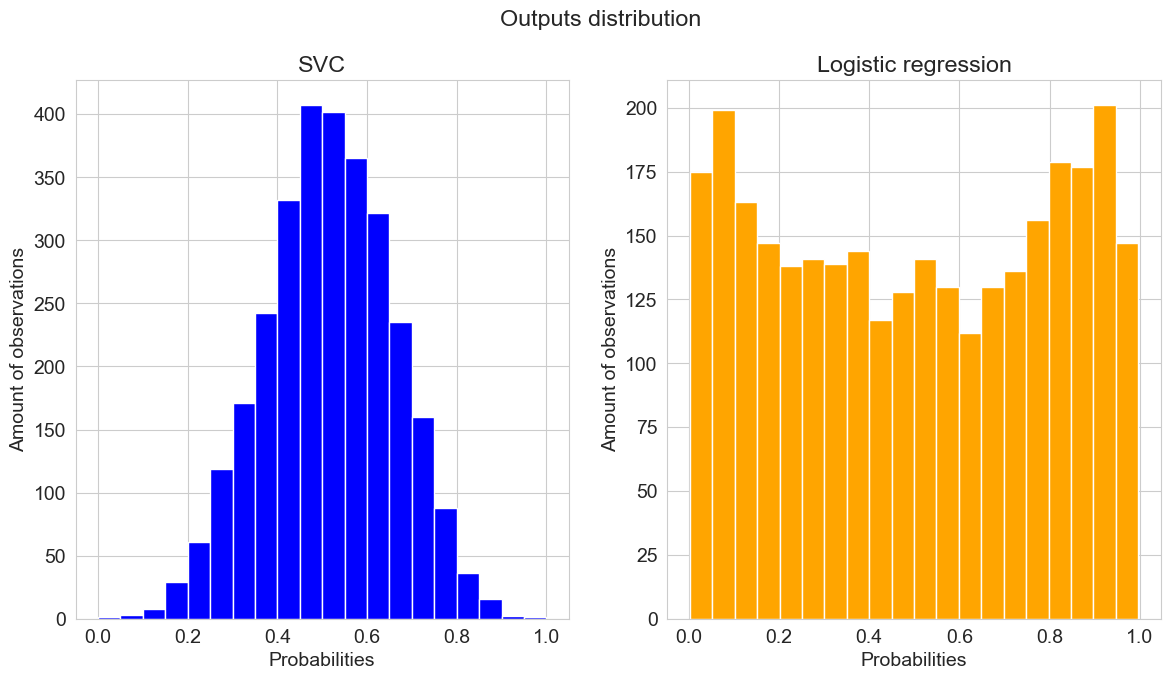

In [225]:
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, bins=20, color='blue')
axs[1].hist(logreg_pred, bins=20, color='orange')

axs[0].set_xlabel('Probabilities')
axs[1].set_xlabel('Probabilities')

axs[0].set_ylabel('Amount of observations')
axs[1].set_ylabel('Amount of observations')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Кажется, что на графиках видно, что SVC действительно плохо предсказывает вероятности: на большенстве объектов модель сомневается и выдает какую-то среднюю вероятность (ну и вообще распределение похоже на нормальное)

В то же время LR делит на классы более уверенно: у нее много наблюдений, где модель однозначно относит объекты к 0 классу и много наблюдений, где однозначно относит к первому. 

То есть становится очевидно, что SVC просто старается отнести объект к какому-то классу, а LR еще и предсказывает хорошие вероятности

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

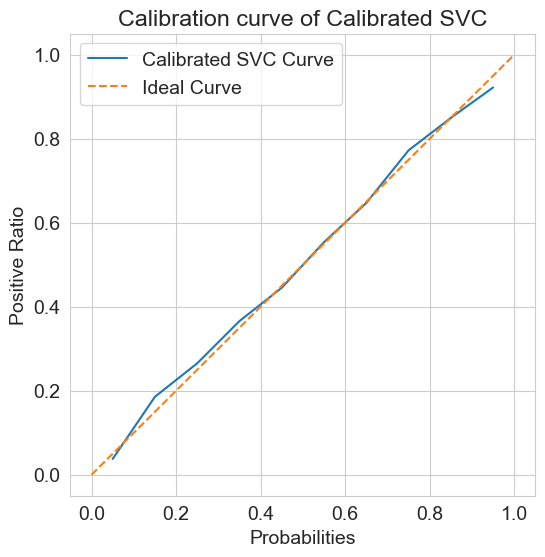

In [226]:
from sklearn.calibration import CalibratedClassifierCV

svc = LinearSVC(max_iter=100000, C=1e-5)
svc.fit(X_train, y_train)

calibrated_svc = CalibratedClassifierCV(svc)
calibrated_svc.fit(X_train, y_train)

calibrated_svc_pred = calibrated_svc.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, calibrated_svc_pred, 'Calibrated SVC')

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Очевидно, что да, кривая стала почти полностью повторять диагональ 

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

Реализуем Platt:

Хотим подобрать такие параметры A и B в исходной формуле, чтобы минимизировать log-loss (именно эта функция потерь дает нам хорошие вероятности)

По train выборке подберем эти параметры A B и просто применим сигмоиду с этими параметрами для test выборки.

Можно минимизировать лосс градиентным спуском, но я считерил и минимизирую готовым методом из scipy (сори)



A: -2.7126153614997115
B: 0.004297234327130953


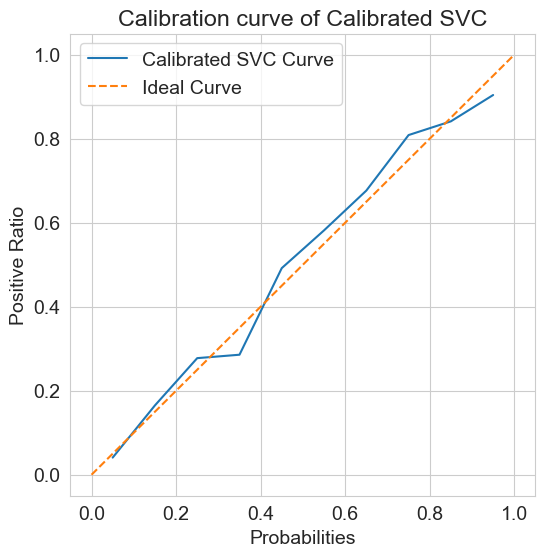

In [249]:
from scipy.optimize import minimize
from sklearn.metrics import log_loss

def sigmoid(x, A, B):
    return 1 / (1 + np.exp(A * x + B))

def loss(params, X, y):
    A, B = params
    predictions = sigmoid(X, A, B)
    return log_loss(y, predictions)

base_classifier = LinearSVC()
base_classifier.fit(X_train, y_train)

train_preds = base_classifier.decision_function(X_train)

initial_params = [0, 0]
optimal_params = minimize(loss, initial_params, args=(train_preds, y_train), method='Nelder-Mead').x

A, B = optimal_params

print("A:", A)
print("B:", B)

test_preds = base_classifier.decision_function(X_test)
calibrated_probs = sigmoid(test_preds, A, B)

plot_calibration_curve(y_test, calibrated_probs, 'Calibrated SVC')

Как видим, у нас получилась нормальная такая кривая

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [323]:
df = pd.read_csv('bike_buyers.csv')
numeric_features = ['Income', 'Cars', 'Children', 'Age']
categorical_features = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']

In [324]:
df.isna().sum()

ID                   0
Marital Status       7
Gender              11
Income               6
Children             8
Education            0
Occupation           0
Home Owner           4
Cars                 9
Commute Distance     0
Region               0
Age                  8
Purchased Bike       0
dtype: int64

In [325]:
df[categorical_features] = df[categorical_features].fillna('undefined')

In [326]:
df.isna().sum()

ID                  0
Marital Status      0
Gender              0
Income              6
Children            8
Education           0
Occupation          0
Home Owner          0
Cars                9
Commute Distance    0
Region              0
Age                 8
Purchased Bike      0
dtype: int64

In [327]:
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = X[numeric_features]
X_categorical = X[categorical_features]

В начале поработаем только с категориальными признаками

In [328]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)


#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [329]:
from sklearn.preprocessing import OrdinalEncoder
from time import time

start = time()

enc = OrdinalEncoder()
X_train = enc.fit_transform(X_train)
X_test = enc.transform(X_test)
lr_ordinal = LogisticRegression(max_iter=100000).fit(X_train, y_train)
print("Time:", time() - start)

Time: 0.028007030487060547


In [330]:
logreg_pred = lr_ordinal.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.57894


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [331]:
from sklearn.preprocessing import OneHotEncoder

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)


In [332]:
start = time()

ohe_enc = OneHotEncoder()
X_train = ohe_enc.fit_transform(X_train)
X_test = ohe_enc.transform(X_test)
lr_ordinal = LogisticRegression(max_iter=100000).fit(X_train, y_train)
print("Time:", time() - start)

Time: 0.024752140045166016


In [333]:
logreg_pred = lr_ordinal.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.66186


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [565]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)
start = time()

concatenated = X_train.copy()
concatenated['y'] = y_train
feature_to_group = {feature: concatenated.groupby(feature)['y'].mean() 
                         for feature in categorical_features}


for feature, m in feature_to_group.items():
    X_train[feature] = X_train[feature].map(m)

for feature, m in feature_to_group.items():
    X_test[feature] = X_test[feature].map(m)


lr_mte = LogisticRegression(max_iter=100000).fit(X_train, y_train)

print("Time:", time() - start)

logreg_pred = lr_mte.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


Time: 0.019181013107299805
AUC-PR: 0.65269


Видим, что качество модели упало (наверное, из-за переобучения)

Время на кодирование и fit также стало меньше 

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [568]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)


from sklearn.base import BaseEstimator, TransformerMixin


class MeanTargetEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.feature_to_group = {}
        
    def fit(self, X, y):
        concatenated = X.copy()
        concatenated['y'] = y
        self.feature_to_group = {feature: concatenated.groupby(feature)['y'].mean() 
                                 for feature in self.categorical_features}
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for feature, m in self.feature_to_group.items():
            X_transformed[feature] = X_transformed[feature].map(m)
        return X_transformed

mte_enc = MeanTargetEncoderTransformer(categorical_features)
X_train_mte = mte_enc.fit_transform(X_train, y_train)
X_test_mte = mte_enc.transform(X_test)

lr_mte = LogisticRegression(max_iter=100000).fit(X_train_mte, y_train)


logreg_pred = lr_mte.predict_proba(X_test_mte)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.65269


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [672]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)


class MeanTargetEncoderTransformerWithNoise(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, std):
        self.categorical_features = categorical_features
        self.feature_to_group = {}
        self.std = std
        
    def fit(self, X, y):
        concatenated = X.copy()
        concatenated['y'] = y
        self.feature_to_group = {feature: concatenated.groupby(feature)['y'].mean() 
                                 for feature in self.categorical_features}
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for feature, m in self.feature_to_group.items():
            X_transformed[feature] = X_transformed[feature].map(m) + np.random.normal(0, scale=self.std, size=X_transformed[feature].shape[0])
        return X_transformed

mte_enc_noise = MeanTargetEncoderTransformerWithNoise(categorical_features, 0.009)
X_train_noise = mte_enc_noise.fit_transform(X_train, y_train)
X_test_noise = mte_enc_noise.transform(X_test)

lr_mte_noise = LogisticRegression(max_iter=100000).fit(X_train_noise, y_train)

logreg_pred = lr_mte_noise.predict_proba(X_test_noise)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.65910


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Кажется, что помогло, улучшение качества есть. Вероятно, шум просто помогает модели не переобучаться и увеличивает ее обобщающую способность

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




Реализуем метод разбиения данных на фолды

In [674]:
from sklearn.model_selection import KFold
from collections import OrderedDict

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

class MeanTargetEncoderTransformerFolds(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, std, folds_amount):
        self.features = categorical_features
        self.fold_to_feature_dict = OrderedDict()
        self.std = std
        self.kf = None
        self.folds_amount = folds_amount
        
    def fit(self, X, y):
        concatenated = X.copy()
        concatenated['y'] = y
        
        kf = KFold(n_splits=self.folds_amount)
        self.kf = kf.split(concatenated)
        
        for i, (train_index, test_index) in enumerate(self.kf):
            self.fold_to_feature_dict[tuple(test_index)] = OrderedDict()
            for feature in self.features:
                self.fold_to_feature_dict[tuple(test_index)][feature] = concatenated.iloc[train_index].groupby(feature)['y'].mean()
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        kf = KFold(n_splits=self.folds_amount).split(X_transformed)
            
        for (fold_index, feature_to_group), (train_ind, test_ind) in zip(self.fold_to_feature_dict.items(), kf):
            for feature, group in feature_to_group.items():
                test_labels = X_transformed.index[test_ind]
                X_transformed.loc[test_labels, feature] = X_transformed.loc[test_labels, feature].map(group) + np.random.normal(0, scale=self.std)
        return X_transformed
    
mte_enc_folds = MeanTargetEncoderTransformerFolds(categorical_features, 0.009, 5)
X_train_folds = mte_enc_folds.fit_transform(X_train, y_train)
X_test_fold = mte_enc_folds.transform(X_test)

lr_mte_fold = LogisticRegression(max_iter=100000).fit(X_train_folds, y_train)

logreg_pred = lr_mte_fold.predict_proba(X_test_fold)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.66264


#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [804]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)


class MeanTargetEncoderTransformerSmooth(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, C):
        self.categorical_features = categorical_features
        self.feature_to_group = {}
        self.C = C
        self.global_mean = None
        
    def fit(self, X, y):
        concatenated = X.copy()
        concatenated['y'] = y
        self.global_mean = y.mean()
        for feature in self.categorical_features:
            gr = concatenated.groupby(feature)['y']
            self.feature_to_group[feature] = (gr.sum() + self.C * self.global_mean) / (gr.size() + self.C)
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for feature, m in self.feature_to_group.items():
            X_transformed[feature] = X_transformed[feature].map(m)
        return X_transformed

mte_enc_prior = MeanTargetEncoderTransformerSmooth(categorical_features, C=10)
X_train_prior = mte_enc_prior.fit_transform(X_train, y_train)
X_test_prior = mte_enc_prior.transform(X_test)

lr_mte_prior = LogisticRegression(max_iter=100000).fit(X_train_prior, y_train)

logreg_pred = lr_mte_prior.predict_proba(X_test_prior)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.66977


Получилось больше чем на ohe, успех

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [890]:
#your code here
X = df[categorical_features + numeric_features]

X[numeric_features] = X[numeric_features].fillna(X[numeric_features].mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)


In [891]:
X_train.isna().sum()

Marital Status      0
Gender              0
Education           0
Occupation          0
Home Owner          0
Commute Distance    0
Region              0
Income              0
Cars                0
Children            0
Age                 0
dtype: int64

In [892]:
X_test.isna().sum()

Marital Status      0
Gender              0
Education           0
Occupation          0
Home Owner          0
Commute Distance    0
Region              0
Income              0
Cars                0
Children            0
Age                 0
dtype: int64

Как видим, если просто обучиться на всех признаках - получится плохо. Я бы сделал Scaling всего этого дела, но вроде о таком пока не просят, поэтому для чистоты эксперимента не будем этого делать (делаем так, как написано в задании)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [893]:
print('Unique Income values:', df['Income'].nunique())
print('Unique Cars values:', df['Cars'].nunique())
print('Unique Children values:', df['Children'].nunique())
print('Unique Age values:', df['Age'].nunique())

Unique Income values: 16
Unique Cars values: 5
Unique Children values: 6
Unique Age values: 53


Значений действительно довольно много, кроме кол-ва машин и детей.

Теперь попробуем закодировать их с помощью счетчиков и посмотреть на результаты

сначала обучимся на всех данных, не будем кодировать numeric features

In [894]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

mte_enc_prior = MeanTargetEncoderTransformerSmooth(categorical_features, C=10)

X_train_copy[categorical_features] = mte_enc_prior.fit_transform(X_train_copy[categorical_features], y_train)
X_test_copy[categorical_features] = mte_enc_prior.transform(X_test_copy[categorical_features])

lr = LogisticRegression(max_iter=100000).fit(X_train_copy, y_train)

logreg_pred = lr.predict_proba(X_test_copy)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.57494


Начнем с кодирования Income

In [897]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

mte_enc_prior = MeanTargetEncoderTransformerSmooth(categorical_features + ['Income'], C=10)

X_train_copy[categorical_features + ['Income']] = mte_enc_prior.fit_transform(X_train_copy[categorical_features + ['Income']], y_train)
X_test_copy[categorical_features + ['Income']] = mte_enc_prior.transform(X_test_copy[categorical_features + ['Income']])

lr = LogisticRegression(max_iter=100000).fit(X_train_copy, y_train)

logreg_pred = lr.predict_proba(X_test_copy)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.67538


Теперь Cars

In [898]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

mte_enc_prior = MeanTargetEncoderTransformerSmooth(categorical_features + ['Cars'], C=10)

X_train_copy[categorical_features + ['Cars']] = mte_enc_prior.fit_transform(X_train_copy[categorical_features + ['Cars']], y_train)
X_test_copy[categorical_features + ['Cars']] = mte_enc_prior.transform(X_test_copy[categorical_features + ['Cars']])

lr = LogisticRegression(max_iter=100000).fit(X_train_copy, y_train)

logreg_pred = lr.predict_proba(X_test_copy)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.57357


Children 

In [900]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

mte_enc_prior = MeanTargetEncoderTransformerSmooth(categorical_features + ['Children'], C=10)

X_train_copy[categorical_features + ['Children']] = mte_enc_prior.fit_transform(X_train_copy[categorical_features + ['Children']], y_train)
X_test_copy[categorical_features + ['Children']] = mte_enc_prior.transform(X_test_copy[categorical_features + ['Children']])

lr = LogisticRegression(max_iter=100000).fit(X_train_copy, y_train)

logreg_pred = lr.predict_proba(X_test_copy)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.57465


Age

In [901]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

mte_enc_prior = MeanTargetEncoderTransformerSmooth(categorical_features + ['Age'], C=10)

X_train_copy[categorical_features + ['Age']] = mte_enc_prior.fit_transform(X_train_copy[categorical_features + ['Age']], y_train)
X_test_copy[categorical_features + ['Age']] = mte_enc_prior.transform(X_test_copy[categorical_features + ['Age']])

lr = LogisticRegression(max_iter=100000).fit(X_train_copy, y_train)

logreg_pred = lr.predict_proba(X_test_copy)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.44210


А теперь все вместе


In [902]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

mte_enc_prior = MeanTargetEncoderTransformerSmooth(categorical_features + numeric_features, C=10)

X_train_copy[categorical_features + numeric_features] = mte_enc_prior.fit_transform(X_train_copy[categorical_features + numeric_features], y_train)
X_test_copy[categorical_features + numeric_features] = mte_enc_prior.transform(X_test_copy[categorical_features + numeric_features])

lr = LogisticRegression(max_iter=100000).fit(X_train_copy, y_train)

logreg_pred = lr.predict_proba(X_test_copy)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, logreg_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.66542


Получается что лучший вариант, когда мы кодируем только Income. Во всех остальных ситуациях получается что-то странное.

Плюс ко всему, хочется сделать скейлинг, так как income явно выбивается из общем картины из-за явно другого масштаба. Я не очень понял суть данного задания, мы вообще не прибавили никакого качества (кроме того когда закодировали Income) и сделали что-то бессмысленное с точки зрения качества.

Наверное, вывод можно сделать такой: кодировать MTE числовые признаки довольно плохая затея и стоит несколько раз подумать, прежде чем это делать.

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__

1) Преимущество MTE заключается в том, что мы не раздуваем пространство признаков, как в OHE. Следовательно это будет работать быстрее. Когда категорий очень много и нам важна скорость, наверное это имеет смысл

2) OHE дает лучшее качество, хоть и работает дольше. Так что если кол-во категорий адекватное, лучше сделать его

Также хочется отметить, что некоторые приемы MTE довольно странные. Например, добавление шума дает непредсказуемые скачки качества и результаты экспериментов становятся не слишком репрезентативными.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [1090]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-17 20:42:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.2’

adult.data.2            [       <=>          ]   3,79M  1,34MB/s    in 2,8s    

2023-11-17 20:42:58 (1,34 MB/s) - ‘adult.data.2’ saved [3974305]



In [1091]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
16856,71,Private,196610,7th-8th,4,Widowed,Exec-managerial,Not-in-family,White,Male,6097,0,40,United-States,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [981]:
features = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country']

X_train, X_test, y_train, y_test = train_test_split(df[features], df['income'], test_size=0.25, random_state=777, stratify=df['income'])


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [982]:
amount_of_features_before_ohe = X_train.shape[1]
amount_of_features_before_ohe

14

In [983]:
categorical_features = [
                        'workclass',
                        'education',
                        'marital-status',
                        'occupation',
                        'relationship',
                        'race',
                        'sex',
                        'native-country'
                        ]

numeric_features = [
                    'age',
                    'fnlwgt',
                    'education-num',
                    'capital-gain',
                    'capital-loss',
                    'hours-per-week'
                    ]

ohe_enc = OneHotEncoder()
X_train = ohe_enc.fit_transform(X_train[categorical_features], y_train)
X_test = ohe_enc.transform(X_test[categorical_features])

print('Признаков после кодирования:', X_train.shape[1])
print('Стало больше на:', X_train.shape[1] - amount_of_features_before_ohe)

Признаков после кодирования: 102
Стало больше на: 88


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [984]:
lr = LogisticRegression(max_iter=100000)

lr.fit(X_train, y_train)
pred = lr.predict_proba(X_test)[:, 1]


precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.68613


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [985]:
start = time()
lr = LogisticRegression(max_iter=100000)

lr.fit(X_train, y_train)

weights = np.abs(lr.coef_[0])
indexes = np.argsort(weights)[::-1][:40]

X_train_top40 = X_train[:, indexes]
X_test_top40 = X_test[:, indexes]

end = time()

lr.fit(X_train_top40, y_train)
pred = lr.predict_proba(X_test_top40)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

print("Time:", end - start)

AUC-PR: 0.66876
Time: 0.24756622314453125


Изменилось ли качество? Как?

Качество немного ухудшилось 

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

Сначала пересчитаем качество на всех признаках, но отскейлим числовые

In [986]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df[features], df['income'], test_size=0.25, random_state=777, stratify=df['income'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('transform', column_transformer),
    ('logistic_regression', LogisticRegression(max_iter=100000))
])

pipeline.fit(X_train, y_train)
pred = pipeline.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.76712


Получили качество сильно лучше, чем без скейлинга, что логично

Теперь отберем лучшие признаки

In [988]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df['income'], test_size=0.25, random_state=777, stratify=df['income'])

X_train = column_transformer.fit_transform(X_train, y_train)
X_test = column_transformer.transform(X_test)

lr = LogisticRegression(max_iter=100000)

lr.fit(X_train, y_train)

weights = np.abs(lr.coef_[0])
indexes = np.argsort(weights)[::-1][:40]

X_train_top40 = X_train[:, indexes]
X_test_top40 = X_test[:, indexes]

lr.fit(X_train_top40, y_train)
pred = lr.predict_proba(X_test_top40)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.73860


Хм..ну кажется с отбором всегда получается хуже. Выиграл вариант просто со скейлингом

Вообще наверное странная идея так отбирать признаки. Логичнее уж тогда сделать лассо-регрессию (добавить l1-регуляризацию) и посмотреть, что он нам занулит. Но опять же не факт что будет прирост в качестве


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [989]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False), categorical_features),
])

X_train, X_test, y_train, y_test = train_test_split(df[features], df['income'], test_size=0.25, random_state=777, stratify=df['income'])

X_train = column_transformer.fit_transform(X_train, y_train)
X_test = column_transformer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)


lr = LogisticRegression(max_iter=100000)

lr.fit(X_train, y_train)

weights = np.abs(lr.coef_[0])
indexes = np.argsort(weights)[::-1][:40]

X_train_top40 = X_train[:, indexes]
X_test_top40 = X_test[:, indexes]

lr.fit(X_train_top40, y_train)
pred = lr.predict_proba(X_test_top40)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.68112


In [990]:
print(set(indexes1) - set(indexes))

{66, 69, 70, 71, 90, 45, 77, 82, 87, 26, 61, 62}


Во-первых, список самых важных фичей поменялся

Во-вторых, скейлить ohe фичи кажется плохой идеей, мы получили очень плохое качество 

Почему так?

Мат ожидание бинарной переменной = p, дисперсия = p(1-p). При скейлинге получаем, что 0 заменяется на -1/sqrt(p), а 1 на 1/sqrt(1–p)

если p было маленькой, то тут вылезают большие числа и мы получаем просто дичь 

вывод: скейлить после ohe - дичь

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [1014]:
X_train[y_train == 0].shape

(18539, 102)

In [1038]:
class FilterMethodsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_amount_to_stay=40):
        self.feature_amount_to_stay = feature_amount_to_stay
        self.t_statistics = []
        
    def fit(self, X, y):
        positive_mask = y == 1
        negative_mask = y == 0
        # цикл по номеру фичи
        for i in range(X.shape[1]):
            numerator = np.abs(X[:, i][positive_mask].mean() - X[:, i][negative_mask].mean())
            denumerator = np.sqrt((positive_mask.sum() * (np.std(X[:, i][positive_mask]) ** 2) +
                                   negative_mask.sum() * (np.std(X[:, i][negative_mask]) ** 2)) / 
                                   (positive_mask.sum() + negative_mask.sum()))
            self.t_statistics.append(numerator / denumerator)
        return self
        
    def transform(self, X):
        X_transformed = X.copy()
        indexes = np.argsort(self.t_statistics)[::-1]
        return X_transformed[:, indexes[:self.feature_amount_to_stay]]
                           
X_train, X_test, y_train, y_test = train_test_split(df[features], df['income'], test_size=0.25, random_state=777, stratify=df['income'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('transform', column_transformer),
    ('filter', FilterMethodsTransformer()),
    ('logistic_regression', LogisticRegression(max_iter=100000))
])

pipeline.fit(X_train, y_train)
pred = pipeline.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.76199


Тут мы получили намного меньшую потерю качества, по сравнению с методом, когда не выкидывали признаки вообще. 

Это можно объяснить тем, что тут мы использовали статистический критерий, а не тупое выкидывание по весам модели. 

То есть мы построили статистику, величина которой оценивает, какой вклад в определение класса этот признак вносит. И если такой вклад маленький, то признак нам не нужен. 

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [1075]:
from tqdm import tqdm
import copy

X_train, X_test, y_train, y_test = train_test_split(df[features], df['income'], test_size=0.25, random_state=777, stratify=df['income'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

start = time()
best_features = list(range(X_train.shape[1]))

while len(best_features) > 40:
    feature_to_score = []
    
    for feature in tqdm(best_features):
        new_list = copy.deepcopy(best_features)
        new_list.remove(feature)
        
        lr.fit(X_train2[:, new_list], y_train2)
        
        pred = lr.predict_proba(X_val[:, new_list])[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, pred)
        
        score = auc(recall, precision)
        feature_to_score.append((feature, score))
    
    minimal_score = max(feature_to_score, key=lambda x: x[1])
    best_features.remove(minimal_score[0])
print("Time:", time() - start) 

100%|████████████████████████████████████████| 41/41 [00:04<00:00,  8.92it/s]

Time: 1154.004502773285


In [1076]:

logreg = LogisticRegression(max_iter=100000)
logreg.fit(X_train2[:, best_features], y_train2)
pred = logreg.predict_proba(X_test[:, best_features])[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.76420


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [1079]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df['income'], test_size=0.25, random_state=777, stratify=df['income'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

start = time()

all_features = list(range(X_train.shape[1]))
best_features = []

while len(best_features) < 40:
    feature_to_score = []
    
    for feature in tqdm(all_features):
        new_list = copy.deepcopy(best_features)
        new_list.append(feature)
        
        lr.fit(X_train2[:, new_list], y_train2)
        
        pred = lr.predict_proba(X_val[:, new_list])[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, pred)
        
        score = auc(recall, precision)
        feature_to_score.append((feature, score))
    
    minimal_score = max(feature_to_score, key=lambda x: x[1])
    best_features.append(minimal_score[0])
    all_features.remove(minimal_score[0])
print("Time:", time() - start)


100%|████████████████████████████████████████| 69/69 [00:08<00:00,  8.45it/s]

Time: 254.57390213012695


In [1082]:
len(best_features)

40

In [1080]:

logreg = LogisticRegression(max_iter=100000)
logreg.fit(X_train2[:, best_features], y_train2)
pred = logreg.predict_proba(X_test[:, best_features])[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.76426


Посмотрим, найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели

In [1092]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df['income'], test_size=0.25, random_state=777, stratify=df['income'])

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False), categorical_features),
    ('scaler', StandardScaler(), numeric_features)
])

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777, stratify=y_train)

start = time()

all_features = list(range(X_train.shape[1]))
best_features = []

ind = 0
scores = [-1]
while True:
    ind += 1
    feature_to_score = []
    
    for feature in tqdm(all_features):
        new_list = copy.deepcopy(best_features)
        new_list.append(feature)
        
        lr.fit(X_train2[:, new_list], y_train2)
        
        pred = lr.predict_proba(X_val[:, new_list])[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, pred)
        
        score = auc(recall, precision)
        feature_to_score.append((feature, score))
    
    minimal_score = max(feature_to_score, key=lambda x: x[1])
    best_features.append(minimal_score[0])
    all_features.remove(minimal_score[0])
    
    if minimal_score[1] < scores[-1]:
        print('Number of iteration:', ind)
        break
    scores.append(minimal_score[1])
        
print("Time:", time() - start)


100%|████████████████████████████████████████| 42/42 [00:07<00:00,  5.45it/s]

Number of iteration: 67
Time: 346.2920730113983


In [1093]:

logreg = LogisticRegression(max_iter=100000)
logreg.fit(X_train2[:, best_features], y_train2)
pred = logreg.predict_proba(X_test[:, best_features])[:, 1]

precision, recall, _ = precision_recall_curve(y_test, pred)
print('AUC-PR: %.5f' % auc(recall, precision))


AUC-PR: 0.76566


Видимо, такой порог существует:)

если взять 67 фичей, то скор станет еще лучше

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

Видим, что качество примерно похожее, но второй метод дал все-таки результат получше. 

Ну и по времени первый метод работает неадекватно долго, в то время как второй метод работает относительно быстро. В общем, второй метод победил 

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [1097]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip


--2023-11-18 15:50:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.2’

bank-additional.zip     [    <=>             ] 434,15K   562KB/s    in 0,8s    

2023-11-18 15:50:57 (562 KB/s) - ‘bank-additional.zip.2’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1220]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [1221]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [1222]:
from sklearn.metrics import accuracy_score


numeric_features = [
    'age',
    'campaign',
    'pdays',
    'previous',
    'emp.var.rate',
    'cons.price.idx',
    'cons.conf.idx',
    'euribor3m',
    'nr.employed'
]

categorical_features = [
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan',
    'contact',
    'month',
    'day_of_week',
    'poutcome'
]


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('transform', column_transformer),
    ('LR', LogisticRegression(max_iter=100000))
])

kf = KFold(n_splits=5, shuffle=True, random_state=500)
kf = kf.split(X)

for train_idx, test_idx in kf:
    X_tr, y_tr = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]
    
    pipeline.fit(X_tr, y_tr)
    pred_label = pipeline.predict(X_test)
    pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, pred_proba)
    print('AUC-PR: %.5f' % auc(recall, precision))
    print('Accuracy:', accuracy_score(y_test, pred_label))
    print()

AUC-PR: 0.48018
Accuracy: 0.9036173828599174

AUC-PR: 0.43779
Accuracy: 0.8997329448895363

AUC-PR: 0.45010
Accuracy: 0.8968196164117505

AUC-PR: 0.46035
Accuracy: 0.9074905912346728

AUC-PR: 0.43085
Accuracy: 0.8908583222046862



Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [1223]:
bank_earned = []
bank_payed = []

kf = KFold(n_splits=5, shuffle=True, random_state=500)
kf = kf.split(X)

for train_idx, test_idx in kf:
    X_tr, y_tr = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]
    
    pipeline.fit(X_tr, y_tr)
    pred_label = pipeline.predict(X_test)
    
    bank_earned.append((y_test[pred_label == 1] * 10).sum())
    bank_payed.append(pred_label.sum())

In [1224]:
print('Выручка в среднем:', np.mean(bank_earned), '+-', np.std(bank_earned))
print('Заплатим операторам в среднем:', np.mean(bank_payed), '+-', np.std(bank_payed))


Выручка в среднем: 2132.0 +- 104.0
Заплатим операторам в среднем: 324.6 +- 7.989993742175271


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [1225]:
bank_earned = []
bank_payed = []

kf = KFold(n_splits=5, shuffle=True, random_state=500)
kf = kf.split(X)

for train_idx, test_idx in kf:
    X_tr, y_tr = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]
    
    pipeline.fit(X_tr, y_tr)
    pred_label = pipeline.predict(X_test)
    
    bank_earned.append((y_test[pred_label == 1] * np.random.uniform(low=0, high=20, size=y_test[pred_label == 1].shape)).sum())
    bank_payed.append(pred_label.sum())

In [1226]:
print('Выручка в среднем:', np.mean(bank_earned), '+-', np.std(bank_earned))
print('Заплатим операторам в среднем:', np.mean(bank_payed), '+-', np.std(bank_payed))


Выручка в среднем: 2128.4159044855855 +- 124.8617494708728
Заплатим операторам в среднем: 324.6 +- 7.989993742175271


Видим, что средние значения выручки немного выросло (но совсем чуть чуть, в целом могла и упасть, так как каждый клиент приносит рандомное кол-во денег), а также сильно увеличилось отклонение, что логично

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [1242]:
c_param = np.logspace(-6, 2, 25)

fx = []
fy = []
std = []

max_profit = -1000000
best_c = None
std_with_best_c = None


for c in tqdm(c_param):
    kf = KFold(n_splits=5, shuffle=True, random_state=500)
    kf = kf.split(X)
    
    pipeline = Pipeline([
        ('transform', column_transformer),
        ('LR', LogisticRegression(max_iter=100000, C=c))
    ])
    
    bank_earned = []
    bank_payed = []
    
    for train_idx, test_idx in kf:
        X_tr, y_tr = X.iloc[train_idx], y[train_idx]
        X_test, y_test = X.iloc[test_idx], y[test_idx]
        
        pipeline.fit(X_tr, y_tr)
        pred_label = pipeline.predict(X_test)
        
        bank_earned.append((y_test[pred_label == 1] * np.random.uniform(low=0, high=20, size=y_test[pred_label == 1].shape)).sum())
        bank_payed.append(pred_label.sum())
        
    fx.append(c)
    fy.append(np.mean(np.array(bank_earned) - np.array(bank_payed)))
    std.append(np.std(np.array(bank_earned) - np.array(bank_payed)))
    
    if np.mean(np.array(bank_earned) - np.array(bank_payed)) > max_profit:
        max_profit = np.mean(np.array(bank_earned) - np.array(bank_payed))
        best_c = c
        std_with_best_c = np.std(np.array(bank_earned) - np.array(bank_payed))
        
print('Best C:', best_c)
print('Profit with best C:', max_profit)
print('Profit STD with best C:', std_with_best_c)

100%|████████████████████████████████████████| 25/25 [00:32<00:00,  1.31s/it]

Best C: 1.0
Profit with best C: 1905.4092336842855
Profit STD with best C: 129.6312975787833


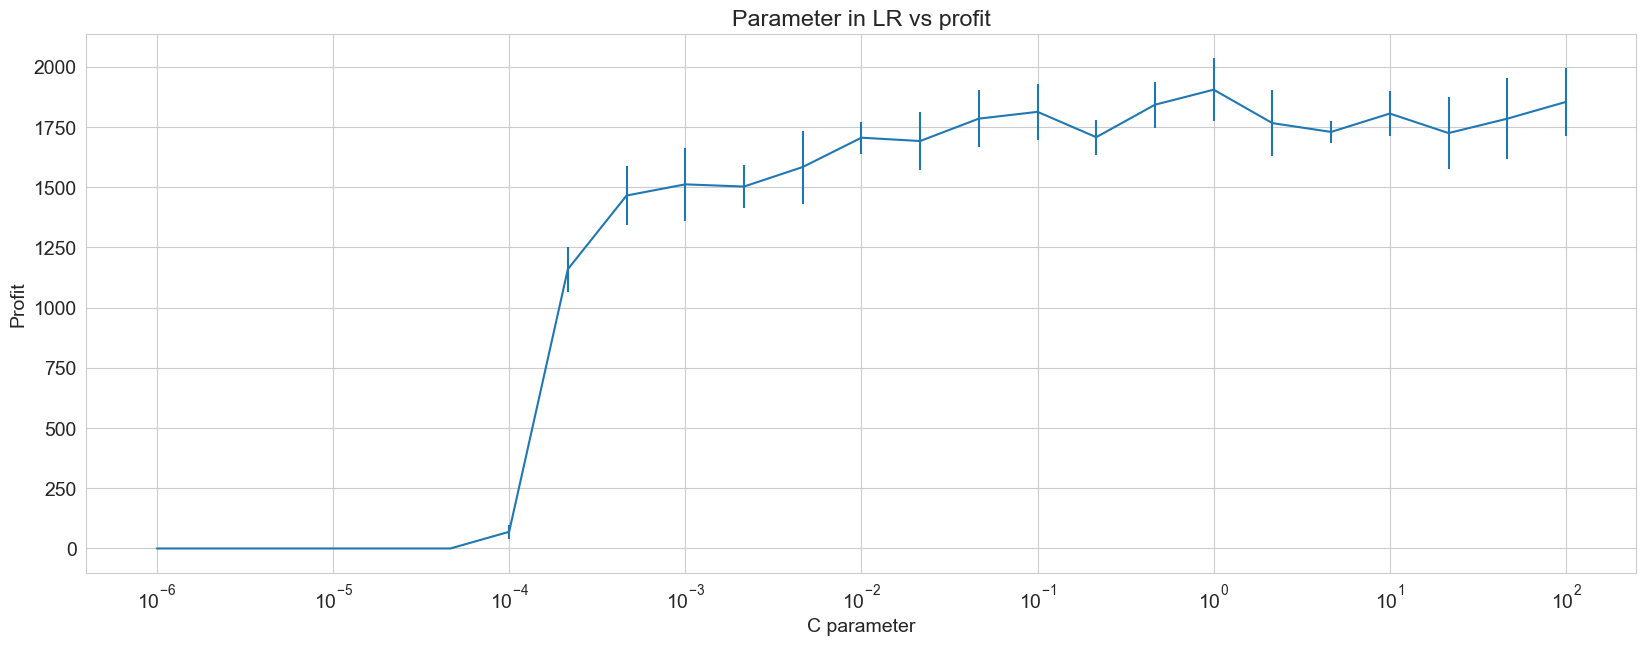

In [1244]:
fig, ax = plt.subplots(figsize=(20, 7))

ax.errorbar(x=fx, y=fy, yerr=std)
ax.set_xscale('log')
ax.set_title('Parameter in LR vs profit')
ax.set_xlabel('C parameter')
ax.set_ylabel('Profit')
plt.show()

Получили прибыль побольше вроде

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [1246]:
c_param = np.logspace(-6, 2, 25)

for _ in range(5):
    max_profit = -1000000
    best_c = None
    std_with_best_c = None


    for c in tqdm(c_param):
        kf = KFold(n_splits=5, shuffle=True, random_state=500)
        kf = kf.split(X)

        pipeline = Pipeline([
            ('transform', column_transformer),
            ('LR', LogisticRegression(max_iter=100000, C=c))
        ])

        bank_earned = []
        bank_payed = []

        for train_idx, test_idx in kf:
            X_tr, y_tr = X.iloc[train_idx], y[train_idx]
            X_test, y_test = X.iloc[test_idx], y[test_idx]

            pipeline.fit(X_tr, y_tr)
            pred_label = pipeline.predict(X_test)

            bank_earned.append((y_test[pred_label == 1] * np.random.uniform(low=0, high=20, size=y_test[pred_label == 1].shape)).sum())
            bank_payed.append(pred_label.sum())

        if np.mean(np.array(bank_earned) - np.array(bank_payed)) > max_profit:
            max_profit = np.mean(np.array(bank_earned) - np.array(bank_payed))
            best_c = c
            std_with_best_c = np.std(np.array(bank_earned) - np.array(bank_payed))

    print('Best C:', best_c)
    print('Profit with best C:', max_profit)
    print('Profit STD with best C:', std_with_best_c)
    print()


100%|████████████████████████████████████████| 25/25 [00:31<00:00,  1.27s/it]


Best C: 46.41588833612773
Profit with best C: 1860.5483899320557
Profit STD with best C: 117.56432843541705



100%|████████████████████████████████████████| 25/25 [00:32<00:00,  1.30s/it]


Best C: 46.41588833612773
Profit with best C: 1880.8485844611155
Profit STD with best C: 139.05709906928072



100%|████████████████████████████████████████| 25/25 [00:32<00:00,  1.28s/it]


Best C: 4.641588833612772
Profit with best C: 1921.3486079873924
Profit STD with best C: 156.79295176644874



100%|████████████████████████████████████████| 25/25 [00:33<00:00,  1.33s/it]


Best C: 4.641588833612772
Profit with best C: 1825.0125064517797
Profit STD with best C: 84.04867961302502



100%|████████████████████████████████████████| 25/25 [00:33<00:00,  1.35s/it]

Best C: 0.1
Profit with best C: 1823.357816334908
Profit STD with best C: 115.35611143181266



В некоторых случаях С совпали, но в общем случае сложно сказать о каких-то выводах из этого. 

Ну и много раз С подобралась довольна большая, что свидетельствует о маленьком коэфе при регуляризаторе. Как будто в общем случае ему выгоднее, чтобы мы поменьше штрафовали за веса.


#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ В этой задаче очевидно важнее полнота, чем точность. Если мы позвоним не тому, кто откроет депозит, особого ущерба не будет (звонок оперетора стоит копейки). Но нам важно, что мы обзвонили как можно больше человек, кто скорее всего согласится, так как они приносят много прибыли



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [1248]:
bin_grid = np.arange(0, 1.01, 0.01)

fx = []
fy = []
std = []

max_profit = -1000000
best_gamma = None


for gamma in tqdm(bin_grid):
    kf = KFold(n_splits=5, shuffle=True, random_state=500)
    kf = kf.split(X)
    
    pipeline = Pipeline([
        ('transform', column_transformer),
        ('LR', LogisticRegression(max_iter=100000))
    ])
    
    bank_earned = []
    bank_payed = []
    
    for train_idx, test_idx in kf:
        X_tr, y_tr = X.iloc[train_idx], y[train_idx]
        X_test, y_test = X.iloc[test_idx], y[test_idx]
        
        pipeline.fit(X_tr, y_tr)
        pred_prob = pipeline.predict_proba(X_test)[:, 1]
        pred_label = (pred_prob >= gamma).astype(int)
        
        bank_earned.append((y_test[pred_label == 1] * np.random.uniform(low=0, high=20, size=y_test[pred_label == 1].shape)).sum())
        bank_payed.append(pred_label.sum())
    
    fx.append(gamma)
    fy.append(np.mean(np.array(bank_earned) - np.array(bank_payed)))
    std.append(np.std(np.array(bank_earned) - np.array(bank_payed)))
    
    if np.mean(np.array(bank_earned) - np.array(bank_payed)) > max_profit:
        max_profit = np.mean(np.array(bank_earned) - np.array(bank_payed))
        best_gamma = gamma
        
print('Best gamma:', best_gamma)
print('Profit with best gamma:', max_profit)


100%|██████████████████████████████████████| 101/101 [03:58<00:00,  2.36s/it]

Best gamma: 0.1
Profit with best gamma: 4324.049641319022


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




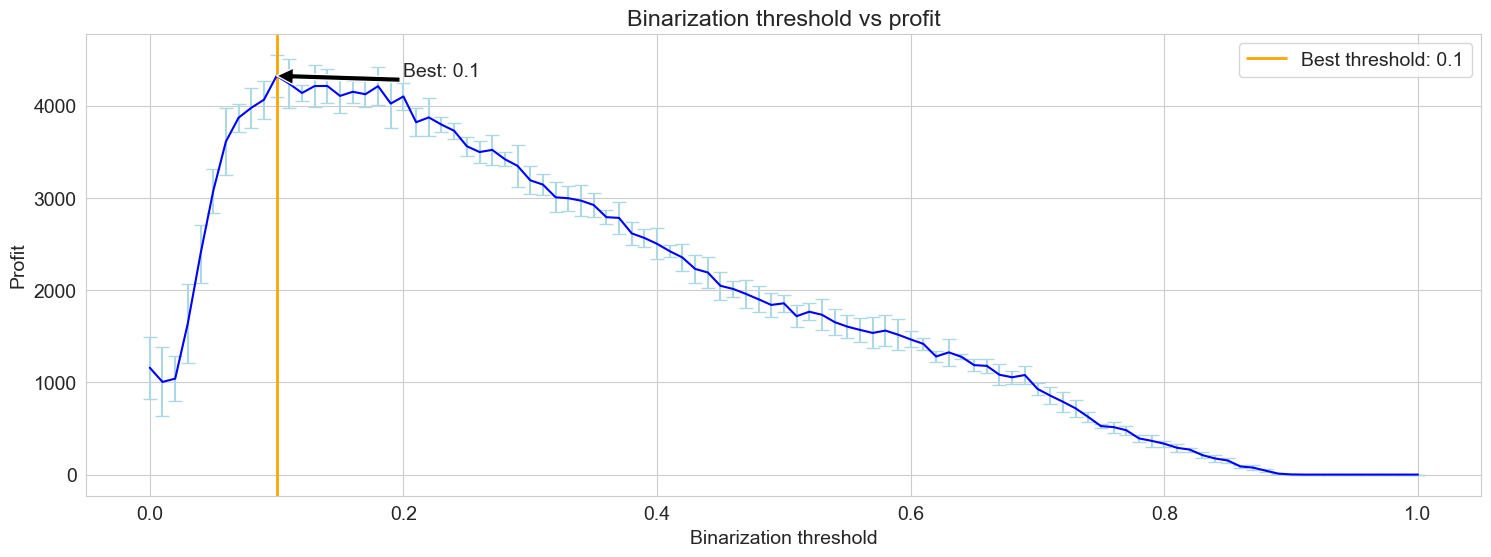

In [1274]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.errorbar(x=fx, y=fy, yerr=std, ecolor='lightblue', color='blue', capsize=5)

ax.set_title('Binarization threshold vs profit')
ax.set_xlabel('Binarization threshold')
ax.set_ylabel('Profit')

ax.axvline(x=best_gamma, color='orange', label=f'Best threshold: {best_gamma}', linewidth=2)

ax.legend()

ax.annotate(f'Best: {best_gamma}', xy=(best_gamma, max(fy)), xytext=(best_gamma+0.1, max(fy)),
             arrowprops=dict(facecolor='black'))

plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [1276]:
bin_grid = np.arange(0, 1.01, 0.01)

fxs = []
fys = []
stds = []
gammas = []

for _ in range(4):
    fx = []
    fy = []
    std = []

    max_profit = -1000000
    best_gamma = None


    for gamma in tqdm(bin_grid):
        kf = KFold(n_splits=5, shuffle=True, random_state=500)
        kf = kf.split(X)

        pipeline = Pipeline([
            ('transform', column_transformer),
            ('LR', LogisticRegression(max_iter=100000))
        ])

        bank_earned = []
        bank_payed = []

        for train_idx, test_idx in kf:
            X_tr, y_tr = X.iloc[train_idx], y[train_idx]
            X_test, y_test = X.iloc[test_idx], y[test_idx]

            pipeline.fit(X_tr, y_tr)
            pred_prob = pipeline.predict_proba(X_test)[:, 1]
            pred_label = (pred_prob >= gamma).astype(int)

            bank_earned.append((y_test[pred_label == 1] * np.random.uniform(low=0, high=20, size=y_test[pred_label == 1].shape)).sum())
            bank_payed.append(pred_label.sum())

        fx.append(gamma)
        fy.append(np.mean(np.array(bank_earned) - np.array(bank_payed)))
        std.append(np.std(np.array(bank_earned) - np.array(bank_payed)))
        
        if np.mean(np.array(bank_earned) - np.array(bank_payed)) > max_profit:
            max_profit = np.mean(np.array(bank_earned) - np.array(bank_payed))
            best_gamma = gamma
    fxs.append(fx)
    fys.append(fy)
    stds.append(std)
    gammas.append(best_gamma)
    print('Best gamma:', best_gamma)
    print('Profit with best gamma:', max_profit)
    print()

100%|██████████████████████████████████████| 101/101 [03:51<00:00,  2.29s/it]


Best gamma: 0.11
Profit with best gamma: 4213.182285989183



100%|██████████████████████████████████████| 101/101 [03:50<00:00,  2.28s/it]


Best gamma: 0.1
Profit with best gamma: 4235.140699694939



100%|██████████████████████████████████████| 101/101 [03:57<00:00,  2.35s/it]


Best gamma: 0.14
Profit with best gamma: 4219.040909835998



100%|██████████████████████████████████████| 101/101 [03:50<00:00,  2.28s/it]

Best gamma: 0.18
Profit with best gamma: 4254.827038787427



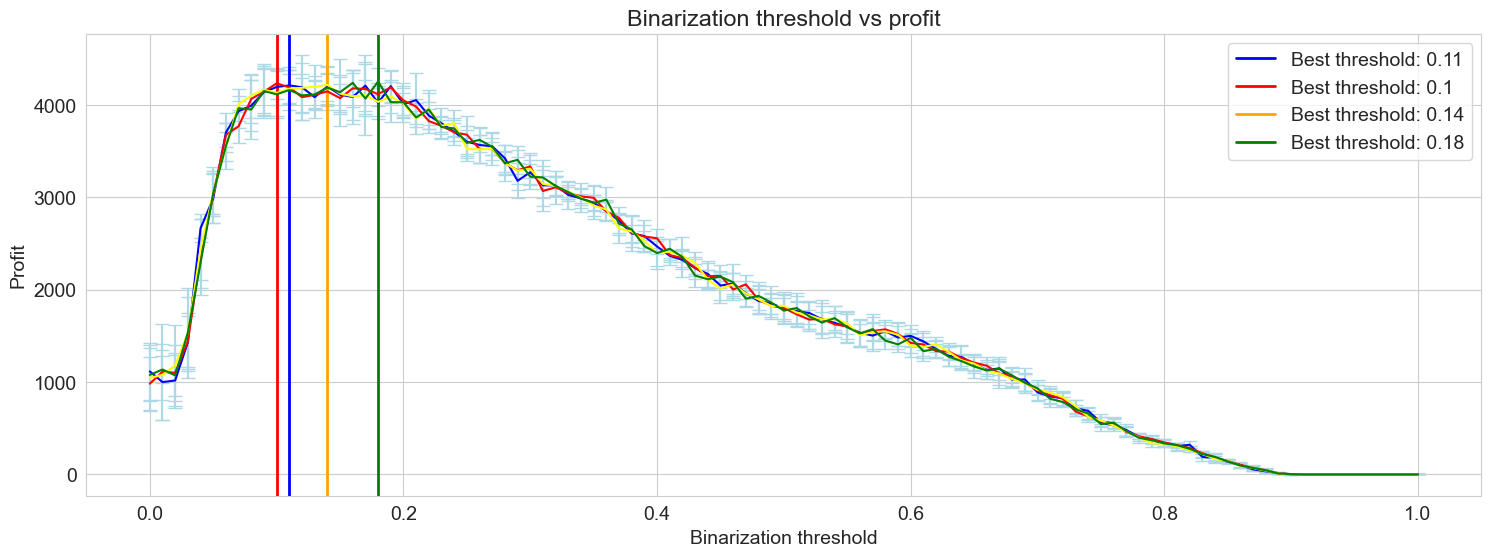

In [1290]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.errorbar(x=fxs[0], y=fys[0], yerr=stds[0], ecolor='lightblue', color='blue', capsize=5)
ax.errorbar(x=fxs[1], y=fys[1], yerr=stds[1], ecolor='lightblue', color='red', capsize=5)
ax.errorbar(x=fxs[2], y=fys[2], yerr=stds[2], ecolor='lightblue', color='yellow', capsize=5)
ax.errorbar(x=fxs[3], y=fys[3], yerr=stds[3], ecolor='lightblue', color='green', capsize=5)

ax.set_title('Binarization threshold vs profit')
ax.set_xlabel('Binarization threshold')
ax.set_ylabel('Profit')

ax.axvline(x=gammas[0], color='blue', label=f'Best threshold: {gammas[0]}', linewidth=2)
ax.axvline(x=gammas[1], color='red', label=f'Best threshold: {gammas[1]}', linewidth=2)
ax.axvline(x=gammas[2], color='orange', label=f'Best threshold: {gammas[2]}', linewidth=2)
ax.axvline(x=gammas[3], color='green', label=f'Best threshold: {gammas[3]}', linewidth=2)

ax.legend()

plt.show()

__Ответ:__ Во-первых, гипотеза подтвердилась: recall действительно важнее

Пороги получаются такие (в окрестности 0.14), так как кажется, что там просто максимум функции прибыли.

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [1288]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


kf = KFold(n_splits=5, shuffle=True, random_state=500)
kf = kf.split(X)

recalls = []
precisions = []

for train_idx, test_idx in kf:
    X_tr, y_tr = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]
    
    pipeline.fit(X_tr, y_tr)
    pred_prob = pipeline.predict_proba(X_test)[:, 1]
    pred_label = pred_prob >= 0.14
    
    precision = precision_score(y_test, pred_label)
    recall = recall_score(y_test, pred_label)
    
    recalls.append(recall)
    precisions.append(precision)

print(f'Recall: {np.mean(recalls)} +- {np.std(recalls)}')
print(f'Precision: {np.mean(precisions)} +- {np.std(precisions)}')

Recall: 0.6079603207268184 +- 0.02077935915877259
Precision: 0.38320591361430323 +- 0.014210287710786952


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

найдем те thl, где recall >= 50

In [1293]:
bin_grid = np.arange(0, 1.01, 0.01)

recalls = []
precisions = []
bin_grid_more = []

recalls_more = []
precisions_more = []

for gamma in tqdm(bin_grid):
    kf = KFold(n_splits=5, shuffle=True, random_state=500)
    kf = kf.split(X)
    
    pipeline = Pipeline([
        ('transform', column_transformer),
        ('LR', LogisticRegression(max_iter=100000))
    ])
    
    bank_earned = []
    bank_payed = []
    
    for train_idx, test_idx in kf:
        X_tr, y_tr = X.iloc[train_idx], y[train_idx]
        X_test, y_test = X.iloc[test_idx], y[test_idx]
        
        pipeline.fit(X_tr, y_tr)
        pred_prob = pipeline.predict_proba(X_test)[:, 1]
        pred_label = (pred_prob >= gamma).astype(int)

        precision = precision_score(y_test, pred_label)
        recall = recall_score(y_test, pred_label)
        
        precisions.append(precision)
        recalls.append(recall)
        
    if np.mean(recalls) >= 0.5:
        bin_grid_more.append(gamma)
        recalls_more.append(np.mean(recalls))
        precisions_more.append(np.mean(precisions))


100%|██████████████████████████████████████| 101/101 [04:09<00:00,  2.47s/it]


In [1295]:
print(bin_grid_more)

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54]


Теперь переведем полученные recalls и prs в отрезок 0, 1

In [1306]:
recalls_more = np.array(recalls_more)
precisions_more = np.array(precisions_more)

recalls_more = (recalls_more - recalls_more.min()) / (recalls_more.max() - recalls_more.min())
precisions_more = (precisions_more - precisions_more.min()) / (precisions_more.max() - precisions_more.min())

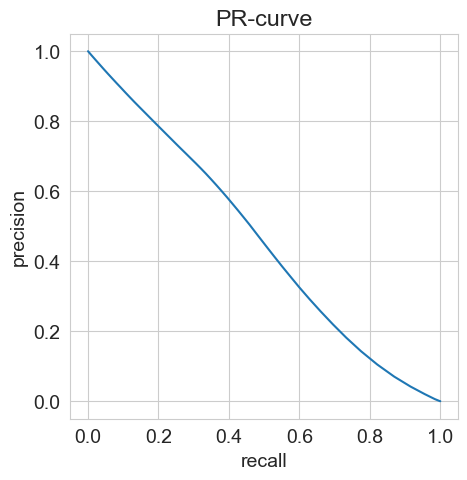

In [1308]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(recalls_more, precisions_more)
ax.set_title('PR-curve')
ax.set_xlabel('recall')
ax.set_ylabel('precision')

plt.show()

Теперь посчитаем площадь под полученным графиком

In [1305]:
auc(recalls_more, precisions_more)

0.4593655876751276

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ омлетик с бутербродиком 